# Prompting on Liar Dataset

## Dataset Setup

In [1]:
import datasets

liar = datasets.load_dataset("liar")
liar

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10269
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1283
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
})

In [2]:
train = liar["train"]
test = liar["test"]
val = liar["validation"]

In [3]:
full_liar = datasets.concatenate_datasets([train, test, val])
full_liar

/home/016854656/miniconda3/envs/torch/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Dataset({
    features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
    num_rows: 12836
})

## Model Loading

In [4]:
falcon = "tiiuae/falcon-7b-instruct"
llama = "meta-llama/Llama-2-7b-chat-hf"
mistral = "mistralai/Mistral-7B-Instruct-v0.2"
orca = "microsoft/Orca-2-7b"

In [6]:
# change this depending on experiment
model_name = llama

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, quantization_config=config, # device_map="auto"
)

/home/016854656/miniconda3/envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/016854656/miniconda3/envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/016854656/miniconda3/envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Experiment

### Experiment Utils

In [8]:
from transformers import PreTrainedTokenizer
from typing import Dict

LABEL_MAP = {
    0: "E",  # 0 : False
    1: "C",  # 1 : Half True
    2: "B",  # 2 : Mostly True
    3: "A",  # 3 : True
    4: "D",  # 4 : Barely True
    5: "F",  # 5 : Pants on Fire
}


def was_correct(
    decoded:str, entry: Dict[str, int]
) -> bool:
    return LABEL_MAP[entry["label"]] in decoded

In [9]:
n_examples = 0

In [15]:
idxs = []
for idx, item in enumerate(full_liar):
    if item['context'] == 'none' or item['context'] == '':
        idxs.append(idx)

In [18]:
full_liar[idxs[0]]

{'id': '610.json',
 'label': 0,
 'statement': 'On using the Strategic Petroleum Reserve.',
 'subject': 'energy',
 'speaker': 'barack-obama',
 'job_title': 'President',
 'state_info': 'Illinois',
 'party_affiliation': 'democrat',
 'barely_true_counts': 70.0,
 'false_counts': 71.0,
 'half_true_counts': 160.0,
 'mostly_true_counts': 163.0,
 'pants_on_fire_counts': 9.0,
 'context': ''}

In [23]:
import random
from typing import List
random.seed(1770)
entries = random.choices(list(range(len(train))), k=n_examples)

def to_zero_shot_prompt(entry: Dict[str, str]) -> str:
    speaker = entry["speaker"].replace("-", " ").title()
    statement = entry["statement"].lstrip("Says ")
    context = entry['context']
    if context != '':
        context = f" made in {context}"
    party = entry['party_affiliation']
    if party != '':
        party = f"{party} "

    prompt = f"""Please select the option that most closely describes the following claim by {party}{speaker}{context}:\n{statement}\n\nA) True\nB) Mostly True\nC) Half True\nD) Barely True\nE) False\nF) Pants on Fire (absurd lie)\n\nChoice: ("""
    return prompt

def to_n_shot_prompt(n: int, entry: Dict[str, str]) -> str:
    examples = ""
    for i in range(n):
        examples += to_zero_shot_prompt(train[entries[i]]) + LABEL_MAP[train[entries[i]]['label']] + "\n\n"
    prompt = to_zero_shot_prompt(entry)
    return examples + prompt

In [24]:
responses: Dict[str, list] = {}

def workflow(idx:int, entry: dict, model, k:int=0, verbose: bool = False) -> bool:
    # encode input, move it to cuda, then generate
    encoded_input = tokenizer(entry['prompt'], return_tensors="pt")
    encoded_input = {item: val.cuda() for item, val in encoded_input.items()}
    generation = model.generate(
        **encoded_input,
        max_new_tokens=1,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

    # log the prompt and response if verbose
    if verbose:
        print(tokenizer.batch_decode(generation)[0])

    decoded = tokenizer.decode(generation[0, -1])
    correct = was_correct(decoded, entry)
    
    if decoded not in responses:
        responses[decoded] = []
    responses[decoded].append(idx)

    if verbose:
        print(
            "The model was",
            "correct" if correct else "incorrect",
            " - responded",
            tokenizer.decode(generation[0, -1]),
            "and answer should have been",
            LABEL_MAP[entry["label"]],
        )
    return correct

### Verify it works

In [25]:
full_liar = full_liar.map(lambda e: {"prompt":to_n_shot_prompt(n_examples, e)})
full_liar

Map:   0%|          | 0/12836 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'prompt'],
    num_rows: 12836
})

In [41]:
import random
workflow(0, full_liar[random.randint(0, len(full_liar) - 1)], model, verbose=True, k=n_examples)

<s> Please select the option that most closely describes the following claim by democrat Hillary Clinton made in a tweet from her campaign:
Donald Trump says hed deport 16 million people.

A) True
B) Mostly True
C) Half True
D) Barely True
E) False
F) Pants on Fire (absurd lie)

Choice: (B
The model was incorrect  - responded B and answer should have been C


False

In [28]:
responses = {}

### Run Experiment

Results of zero-shot prompting the models

In [15]:
dl = torch.utils.data.DataLoader(full_liar, batch_size=8)

In [17]:
responses: Dict[str, list] = {}

# def batched_was_correct(decoded, entry):
#     tensored = 

def workflow_batch(idx:int, entry: dict, model, verbose: bool = False) -> bool:
    # encode input, move it to cuda, then generate
    encoded_input = tokenizer(entry['prompt'], return_tensors="pt", padding='max_length')
    encoded_input = {item: val.cuda() for item, val in encoded_input.items()}
    generation = model.generate(
        **encoded_input,
        max_new_tokens=1,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
    )

    # log the prompt and response if verbose
    if verbose:
        print(tokenizer.batch_decode(generation)[0])

    decoded = tokenizer.decode(generation[:, -1])
    correct = was_correct(decoded, entry)
    
    if decoded not in responses:
        responses[decoded] = []
    responses[decoded].append(idx)

    if verbose:
        print(
            "The model was",
            "correct" if correct else "incorrect",
            " - responded",
            tokenizer.decode(generation[0, -1]),
            "and answer should have been",
            LABEL_MAP[entry["label"]],
        )
    return correct

In [29]:
from tqdm import tqdm

num_correct = 0
responses={}
for idx, entry in enumerate((prog:=tqdm(full_liar))):
    if idx in entries:
        continue  # don't include items that were in the examples
    
    correct = workflow(idx, entry, model, k=n_examples)
    if correct:
        num_correct += 1
    prog.set_postfix_str(f"acc: {num_correct/(idx+1):.3f}")

100%|█████████████████████████████████████| 12836/12836 [30:49<00:00,  6.94it/s]


In [30]:
responses.keys()

dict_keys(['B', 'D', 'A', 'E', 'C', 'M', 'Since', 'T', 'The', 'I', 'F', 'John', 'Ge', 'GM'])

In [34]:
import seaborn as sns
import pandas as pd
sns.set_context("paper")


df = {"labels":[]}
for key, val in responses.items():
    df['labels'].extend([key]*len(val))
df = pd.DataFrame.from_dict(df)

<Axes: xlabel='labels', ylabel='count'>

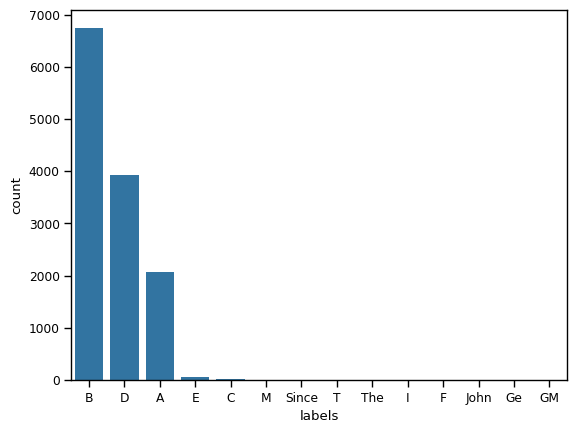

In [35]:
sns.countplot(df, x='labels')

Text(0.5, 1.0, 'meta-llama/Llama-2-7b-chat-hf 0-shot')

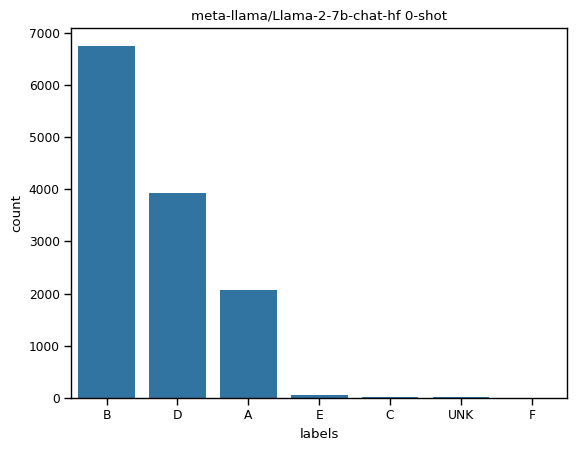

In [39]:
accepted = ['A', 'B', 'C', 'D', 'E','F']
filtered = df.map(lambda val: val if val in accepted else 'UNK')
sns.countplot(filtered, x='labels', ).set_title(f"{model_name} 0-shot")

In [22]:
import pickle
pickle.dump(responses, open(f"{model_name[model_name.index('/')+1:]}_{n_examples}responses.pk", "wb"))

In [23]:
# log results
with open(f"{n_examples}_shot.txt", "a") as file:
    file.write(f"{model_name} : {num_correct}/{len(full_liar)-len(entries)}\n")

In [24]:
# print results up till now
with open(f"{n_examples}_shot.txt", "r") as file:
    print(file.read())

meta-llama/Llama-2-7b-chat-hf : 2755/12835
tiiuae/falcon-7b-instruct : 2466/12835
mistralai/Mistral-7B-Instruct-v0.2 : 2931/12835
microsoft/Orca-2-7b : 2673/12835
microsoft/Orca-2-7b : 2346/12835

